In [50]:
import sys
sys.path.append('./gsw/')

import numpy as np
from gsw.gsw import GSW
from gsw_utils import w2,load_data

import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Function
from torch.nn.parameter import Parameter
from torch import optim

from tqdm import tqdm
from IPython import display
import time
import pickle 
import matplotlib.pyplot as plt
import random
import os

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [51]:
np.random.seed(10)

In [ ]:
# puma
# np_nu1t = np.load("puma.npy")

# plt.figure(figsize=(10,10))
# plt.scatter(np_nu1t[:,0],np_nu1t[:,1],c='b')
# X = np_nu1t
# X = torch.from_numpy(X)
# X -= X.mean(dim=0)[np.newaxis,:]
# meanX = 0
# dataset_name = 'puma'

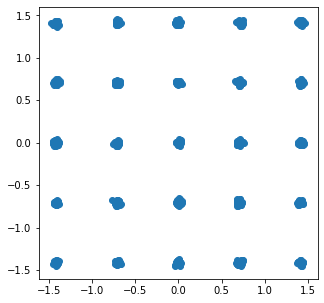

In [52]:
# choose a dataset and show it
dataset_name = '25gaussians' #'circle' or 'swiss_roll'

N = 1000  
X = load_data(name=dataset_name, n_samples=N)
X -= X.mean(dim=0)[np.newaxis,:]
meanX = 0

_, d = X.shape
fig = plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1])
plt.show()

In [53]:
# save results
results_folder = './saved_results_flows'
if not os.path.isdir(results_folder):
    os.mkdir(results_folder)

foldername = os.path.join(results_folder, 'figures')
if not os.path.isdir(foldername):
    os.mkdir(foldername)

foldername = os.path.join(results_folder, 'figures', dataset_name + '_Comparison')
if not os.path.isdir(foldername):
    os.mkdir(foldername)

In [54]:
# some settings
nofiterations = 200

w2_dist = np.nan * np.zeros((nofiterations, 4))
maxw2_dist = np.nan * np.zeros((nofiterations, 3))

modes = ['linear', 'poly', 'poly', 'linear', 'poly', 'poly', 'HCP', 'HCP']
titles = ['Linear', 'Poly 3', 'Poly 5', 'HCP', 'Max Linear', 'Max Poly 3', 'Max Poly 5', 'HCP']
degrees = [3, 3, 5, 3, 3, 5]

In [55]:
# Define the initial distribution
temp = np.random.normal(loc=meanX, scale=.25, size=(X.shape[0],X.shape[1]))

# Define the optimizers
Y = list()
optimizer = list()
gsw = list()

# linear, poly3, poly5
for k in range(3):
    Y.append(torch.tensor(temp, dtype=torch.float, device=device, requires_grad=True))
    optimizer.append(optim.Adam([Y[k]], lr = 1e-2))
    gsw.append([GSW(ftype=modes[j], degree=degrees[j], nofprojections=1) for j in range(k+1)])

# add HCP flow
Y.append(torch.tensor(temp, dtype=torch.float, device=device, requires_grad=True))
optimizer.append(optim.Adam([Y[3]], lr = 1e-2))
gsw.append([GSW(ftype=modes[6], degree=1, nofprojections=1)])

# max linear, max poly3, max poly5
for k in range(3):
    Y.append(torch.tensor(temp, dtype=torch.float, device=device, requires_grad=True))
    optimizer.append(optim.Adam([Y[4 + k]], lr = 1e-2))
    gsw.append([GSW(ftype=modes[j], degree=degrees[j], nofprojections=1) for j in range(k+1)])

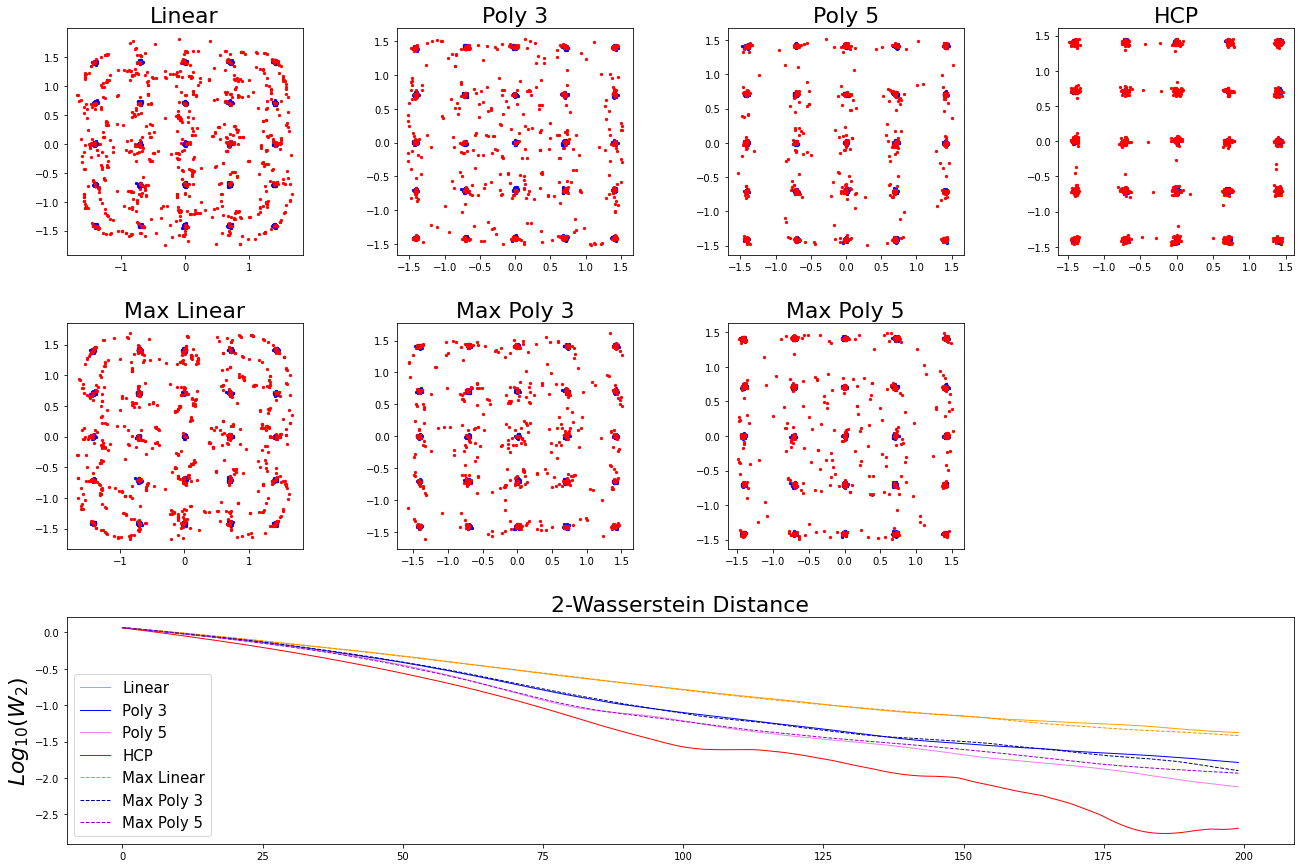

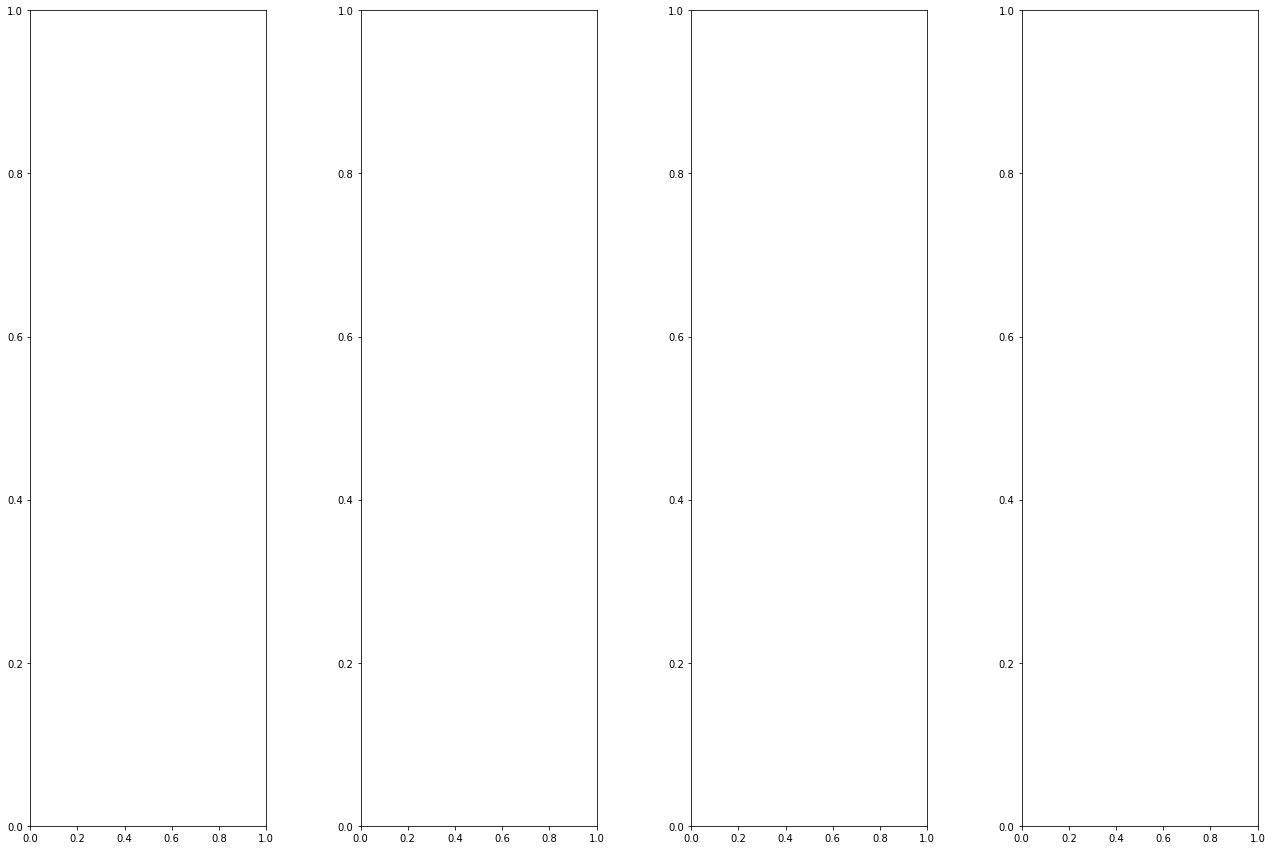

In [56]:
fig = plt.figure(figsize=(22, 15))
grid = plt.GridSpec(3, 4, wspace=0.4, hspace=0.3)
## Though HCP flow converges very fast at the beginning, it may fall into a state of instability because of the high learning rate.
## Hence, if we don't decrease the learning rate, we have to increase p in HCP_p to make the loss sharper.

# for 25 gaussians, first 100 iterations is HCP_2, last 100 iterations is HCP_4
losspp = np.ones(nofiterations)*2
losspp[100:200] = losspp[100:200]*2

# for puma, first 100 iterations is HCP_2, last 100 iterations is HCP_4
# losspp = np.ones(nofiterations)*2
# losspp[100:200] = losspp[100:200]*2

# for circle
# losspp = np.ones(nofiterations)*2

# for swiss_roll
# losspp = np.ones(nofiterations)*2
# k1 = 80
# k2 = 150
# losspp[k1:k2] = losspp[k1:k2]*2
# losspp[k2:200] = losspp[k2:200]*4



for i in range(nofiterations):            
    loss = list()
    for k in range(4):
        loss_ = 0
        for g in gsw[k]:
            if k!=3:
                loss_ += g.gsw(X.to(device),Y[k].to(device))
            else:
                g = GSW(ftype='HCP', degree=1, nofprojections=1, lossp=losspp[i])
                loss_ += g.gsw(X.to(device),Y[k].to(device))
        
        # Optimization step
        loss.append(loss_)
        optimizer[k].zero_grad()
        loss[k].backward()
        optimizer[k].step()
        
        # Compute the 2-Wasserstein distance to compare the distributions
        w2_dist[i, k] = w2(X.detach().cpu().numpy(), Y[k].detach().cpu().numpy())  
        
        # Plot samples from the target and the current solution
        temp = Y[k].detach().cpu().numpy()
        plt.subplot(grid[0, k])
        plt.scatter(X[:, 0], X[:, 1], c='b', s=5)
        plt.scatter(temp[:, 0], temp[:, 1], c='r', s=5) 
        plt.title(titles[k], fontsize=22)
        
    for k in range(4, 7):
        loss_ = 0
        for g in gsw[k]:
            loss_ += g.max_gsw(X.to(device), Y[k].to(device), iterations=200, lr=1e-2)
        
        # Optimization step
        loss.append(loss_)
        optimizer[k].zero_grad()
        loss[k].backward()
        optimizer[k].step()
        
        # Compute the 2-Wasserstein distance to compare the distributions
        maxw2_dist[i, k-4] = w2(X.detach().cpu().numpy(), Y[k].detach().cpu().numpy())  
        
        # Plot samples from the target and the current solution
        temp = Y[k].detach().cpu().numpy()
        plt.subplot(grid[1, k-4])
        plt.scatter(X[:,0], X[:,1], c='b',s=5)
        plt.scatter(temp[:,0], temp[:,1],c='r',s=5) 
        plt.title(titles[k], fontsize=22)

        
    # Plot the 2-Wasserstein distance
    plt.subplot(grid[2, 0:4])
    plt.plot(np.log10(w2_dist[:,0]), linewidth=1, c='orange', label='Linear')
    plt.plot(np.log10(w2_dist[:,1]), linewidth=1, c='blue', label='Poly3')
    plt.plot(np.log10(w2_dist[:,2]), linewidth=1, c='violet', label='Poly5')
    plt.plot(np.log10(w2_dist[:,3]), linewidth=1, c='red', label='HCP')

    plt.plot(np.log10(maxw2_dist[:,0]), linewidth=1, c='darkorange', linestyle='dashed', label='Max Linear')
    plt.plot(np.log10(maxw2_dist[:,1]), linewidth=1, c='darkblue', linestyle='dashed', label='Max Poly3')
    plt.plot(np.log10(maxw2_dist[:,2]), linewidth=1, c='darkviolet', linestyle='dashed', label='Max Poly5')

    plt.title('2-Wasserstein Distance', fontsize=22)
    plt.ylabel(r'$Log_{10}(W_2)$', fontsize=22)
         
    plt.legend(titles, fontsize=15, loc='lower left')
    display.clear_output(wait=True)
    display.display(plt.gcf()) 
    time.sleep(1e-5)
    
    # Save the figure 
    fig.savefig(foldername + '/img%03d.png'%(i))
    for k in range(4):
        plt.subplot(grid[:, k])
        plt.cla()


In [57]:
# save as videos
import cv2

nn = 200
filenames = [None]*nn
for i in range(nn):
    ii = str(i)
    filenames[i] = foldername + '/img' + ii.zfill(3) + '.png'



size = (1000,750)
results_folder_video = './saved_results_flows/videos/'
if not os.path.isdir(results_folder_video):
    os.mkdir(results_folder_video)

videowrite = cv2.VideoWriter(results_folder_video + dataset_name + '_comparison.mp4',cv2.VideoWriter_fourcc(*'mp4v'),10,size)
img_array=[]

for filename in filenames:
    img = cv2.imread(filename)
    img = cv2.resize(img,size)
    img_array.append(img)
    
for i in range(nn):
    videowrite.write(img_array[i])
videowrite.release()
print('end!')

end!
